# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Импорт библиотек

In [1]:
import pandas as pd
import os
import numpy as np
from scipy import stats as st

from matplotlib import pyplot
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pyplot.style.use('seaborn-deep')
state = np.random.RandomState(12345)

### Откроем локальную или веб-версию файлов данных

Напишем функцию поиска файлов на локальном диске или в сети;<br>
После того как файлы найдены, прочтем их, получив детальную сводку.

In [2]:
def find(name, path):
    '''
    Function to find the data file stored locally.
    Takes name of the file and root directory.
    Scanes the local directory tree for the first orrurance of the file.
    '''
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)


online_path = 'datasets'
offline_path = '/home/'
files = ['geo_data_0.csv', 'geo_data_1.csv', 'geo_data_2.csv']
df_list = []

for file in files:
    try:
        df = pd.read_csv(f'/{online_path}/{file}', index_col='id')
        df_list.append(df)
    except FileNotFoundError:
        df = pd.read_csv(find(file, offline_path), index_col='id')
        df_list.append(df)
        print(f"Файл {file} найден на локальном диске.")
    else:
        print(f"Файл {file} открыт в режиме online.")

Файл geo_data_0.csv открыт в режиме online.
Файл geo_data_1.csv открыт в режиме online.
Файл geo_data_2.csv открыт в режиме online.


In [3]:
counter = 0
for file in files:
    start = "\033[1m"
    end = "\033[0;0m"
    print(
        f"Внешний вид первых пяти строк датафрейма {start}{str(file).split('.')[0].upper()}{end}:"
    )
    display(df_list[counter].head())
    print()
    print(f"Размер датафрейма {start}{str(file).split('.')[0].upper()}{end}: \
        \nколичество строк - {df_list[counter].shape[0]}, \nколичество столбцов - {df_list[counter].shape[1]}."
          )
    print()
    print(
        f"Развернутая сводка датафрейма {start}{str(file).split('.')[0].upper()}{end} \nпо наименованию столбцов, типу данных, ненулевых значениях и объему памяти:"
    )
    print()
    df_list[counter].info(memory_usage='deep')
    print(
        '--------------------------------------------------------------------')
    print()

Внешний вид первых пяти строк датафрейма GEO_DATA_0:


,f0,f1,f2,product
id,,,,
txEyH,0.71,-0.50,1.22,105.28
2acmU,1.33,-0.34,4.37,73.04
409Wp,1.02,0.15,1.42,85.27
iJLyR,-0.03,0.14,2.98,168.62
Xdl7t,1.99,0.16,4.75,154.04



Размер датафрейма GEO_DATA_0:         
количество строк - 100000, 
количество столбцов - 4.

Развернутая сводка датафрейма GEO_DATA_0 
по наименованию столбцов, типу данных, ненулевых значениях и объему памяти:

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 9.0 MB
--------------------------------------------------------------------

Внешний вид первых пяти строк датафрейма GEO_DATA_1:


,f0,f1,f2,product
id,,,,
txEyH,0.71,-0.50,1.22,105.28
2acmU,1.33,-0.34,4.37,73.04
409Wp,1.02,0.15,1.42,85.27
iJLyR,-0.03,0.14,2.98,168.62
Xdl7t,1.99,0.16,4.75,154.04



Размер датафрейма GEO_DATA_1:         
количество строк - 100000, 
количество столбцов - 4.

Развернутая сводка датафрейма GEO_DATA_1 
по наименованию столбцов, типу данных, ненулевых значениях и объему памяти:

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 9.0 MB
--------------------------------------------------------------------

Внешний вид первых пяти строк датафрейма GEO_DATA_2:


,f0,f1,f2,product
id,,,,
txEyH,0.71,-0.50,1.22,105.28
2acmU,1.33,-0.34,4.37,73.04
409Wp,1.02,0.15,1.42,85.27
iJLyR,-0.03,0.14,2.98,168.62
Xdl7t,1.99,0.16,4.75,154.04



Размер датафрейма GEO_DATA_2:         
количество строк - 100000, 
количество столбцов - 4.

Развернутая сводка датафрейма GEO_DATA_2 
по наименованию столбцов, типу данных, ненулевых значениях и объему памяти:

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 9.0 MB
--------------------------------------------------------------------



In [4]:
# проверим наличие дубликатов в каждом датафрейме:
for df in df_list:
    print(df.duplicated().sum())

0
0
0


### _Промежуточные выводы_

Данные в датафреймах не имеют пропусков и дубликатов. Типы данных соответствуют реальным данным. Дальнейшая подготовка данных не требуется. 

## Обучение и проверка модели

In [5]:
real_product = []
predictions = []
accuracy_list = []
models_list = []
index_list = []
for df in df_list:
    # разбиваем данные на параметры и целевые значения:
    features = df.drop(['product'], axis=1)
    target = df['product']

    # разделение данных на обучающую и валидационную выборки:
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=state)

    # обучение модели и получение предсказаний:
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = model.score(features_valid, target_valid)

    # сохранение данных:
    index_list.append(features_valid.index)
    real_product.append(target_valid)
    predictions.append(predictions_valid)
    accuracy_list.append(result)
    models_list.append(model)

In [6]:
# распечатка результатов:
for i in range(len(df_list)):

    print()
    print("_______________________________________________________")
    print()
    print(
        f'Accuracy модели на данных датафрейма {files[i]}: {round(accuracy_list[i], 3)}'
    )
    print(
        f'RMSE модели на данных датафрейма {files[i]}: {round(mean_squared_error(real_product[i], predictions[i])**0.5, 3)}'
    )
    print(
        f'Средний запас предсказанного сырья на данных датафрейма {files[i]}: {round(predictions[i].mean(), 3)}'
    )
    print(
        f'Средний фактический запас сырья на данных датафрейма {files[i]}: {round(real_product[i].mean(), 3)}'
    )


_______________________________________________________

Accuracy модели на данных датафрейма geo_data_0.csv: 0.28
RMSE модели на данных датафрейма geo_data_0.csv: 37.579
Средний запас предсказанного сырья на данных датафрейма geo_data_0.csv: 92.593
Средний фактический запас сырья на данных датафрейма geo_data_0.csv: 92.079

_______________________________________________________

Accuracy модели на данных датафрейма geo_data_1.csv: 1.0
RMSE модели на данных датафрейма geo_data_1.csv: 0.89
Средний запас предсказанного сырья на данных датафрейма geo_data_1.csv: 68.77
Средний фактический запас сырья на данных датафрейма geo_data_1.csv: 68.772

_______________________________________________________

Accuracy модели на данных датафрейма geo_data_2.csv: 0.203
RMSE модели на данных датафрейма geo_data_2.csv: 39.958
Средний запас предсказанного сырья на данных датафрейма geo_data_2.csv: 95.088
Средний фактический запас сырья на данных датафрейма geo_data_2.csv: 94.749


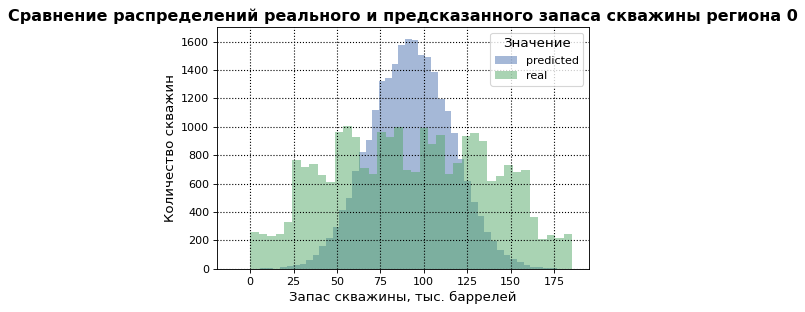

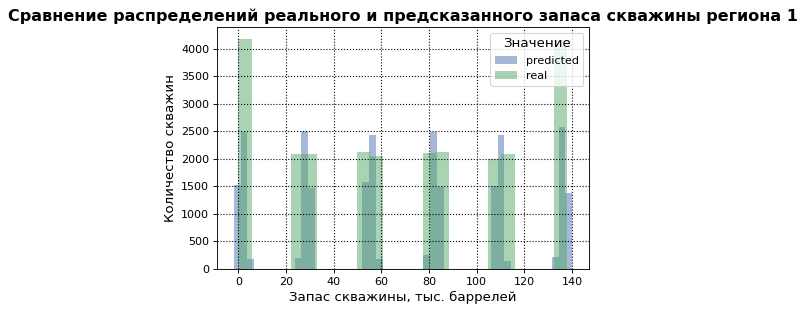

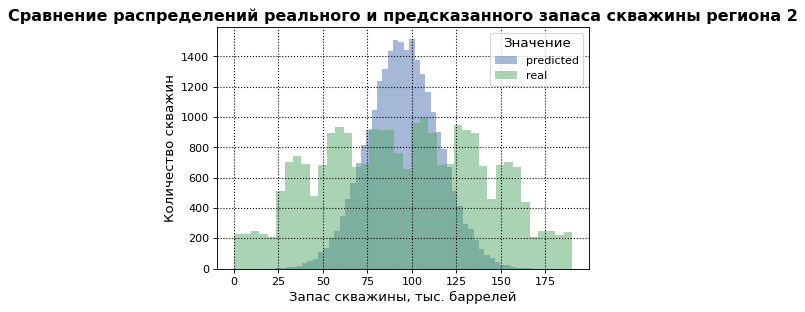

In [7]:
# построим графики распределения фактических и предсказанных запасов для каждого региона:
for x in range(0, 3):
    predicted_plot = predictions[x]
    real_plot = real_product[x]
    #labels =  ultra_avg_monthly_usage.index.month
    figure(figsize=(6, 4), dpi=80)
    pyplot.grid(color='black', linestyle="dotted", linewidth=1)
    pyplot.hist(predicted_plot, bins=50, alpha=0.5, label='predicted')
    pyplot.hist(real_plot, bins='auto', alpha=0.5, label='real')
    pyplot.title(label=f'Сравнение распределений реального и предсказанного запаса скважины региона {x}',
             fontdict={
                 'fontsize': 'x-large',
                 'fontweight': 'semibold'
             })
    pyplot.legend(title='Значение', title_fontsize='large', loc='upper right')
    pyplot.ylabel("Количество скважин", fontsize='large')
    pyplot.xlabel("Запас скважины, тыс. баррелей", fontsize='large')

### _Промежуточные выводы_

Наиболее высокий показатель **accuracy** получен на датафрейме второй территории (источник данных "geo_data_1.csv"). При этом модель предсказала отрицательные значения для части скважин второй территории, а наиболее высокое среднее предсказанное значение запасов сырья получено на третьем датафрейме (источник данных "geo_data_2.csv") 

## Подготовка к расчёту прибыли

In [8]:
# создадим датафреймы для каждого региона, содержащие данные о фактическом и предсказанном запасе сырья:
df_list = []
for x in range(0, 3):
    df = pd.DataFrame(
        {
            'real': real_product[x],
            'predicted': predictions[x]
        },
        index=index_list[x])
    df_list.append(df)

In [9]:
# добавим переменные согласно условиям задачи:  
BUDGET = 10**10
WELLS_TO_EXPLORE = 500
WELLS_TO_DRILL = 200

PROFIT_PER_BARREL = 450_000
BUDGET_PER_WELL = BUDGET / WELLS_TO_DRILL
MIN_REQUIRED_BARRELS_PER_REGION = BUDGET / PROFIT_PER_BARREL
MIN_AVG_WELL_BALANCE = BUDGET_PER_WELL / PROFIT_PER_BARREL

In [10]:
print(
    f'Минимальный уровень добычи в регионе (нулевая рентабельность): {round(MIN_REQUIRED_BARRELS_PER_REGION, 2)}'
)
print(f'Минимальный средний запас скважины: {round(MIN_AVG_WELL_BALANCE, 2)}')

Минимальный уровень добычи в регионе (нулевая рентабельность): 22222.22
Минимальный средний запас скважины: 111.11


In [11]:
# напишем функцию расчета прибыли для территории:
def region_profit_calculator(
    df, count, budget
):  # функция принимает датафрейм с предсказанными и реальными значениями, требуемое количество скважин и размер планируемого бюджета
    df = df.nlargest(
        n=count, columns='predicted'
    )  # отбираем первые n строк по столбцу предсказанных значений
    return PROFIT_PER_BARREL * df.real.sum(
    ) - budget  # суммируем реальные значения полученного датафрейма и рассчитываем рентабельность относительно инвестиций

In [12]:
# проверим работу функции:
print(
    '{:,}'.format(round(region_profit_calculator(df_list[0], 100, BUDGET),
                        2)).replace(',', ' '), "руб.")
print(
    '{:,}'.format(
        round(region_profit_calculator(df_list[0], 100, budget=BUDGET / 2),
              2)).replace(',', ' '), "руб.")
print(
    '{:,}'.format(round(region_profit_calculator(df_list[0], WELLS_TO_DRILL, BUDGET),
                        2)).replace(',', ' '), "руб.")
print(
    '{:,}'.format(round(region_profit_calculator(df_list[0], 500, BUDGET),
                        2)).replace(',', ' '), "руб.")

-3 343 308 241.83 руб.
1 656 691 758.17 руб.
3 320 826 043.14 руб.
22 287 531 170.61 руб.


### _Промежуточные выводы_

Точка безубыточности для региона определена как 2222.22 тыс. баррелей на 200 скважин, или 11.11 тыс. баррелей на одну скважину. 
<br>Средние запасы сырья на скважину в каждом регионе (как предсказанные, так и фактические) значительно выше точки безубыточности на скважину. 

## Расчёт прибыли и рисков 

In [13]:
for x in range(len(df_list)):
    values = []
    for i in range(1000):
        subsample = df_list[x].sample(n=WELLS_TO_EXPLORE,
                                      replace=True,
                                      random_state=state)
        sample_profitability = region_profit_calculator(
            subsample, WELLS_TO_DRILL, BUDGET)
        values.append(sample_profitability)

    values = pd.Series(values)
    mean = values.mean()

    print(
        f'Средняя выручка региона {x}: \t{"{:,}".format(round(mean, 2)).replace(",", " ")}'
    )
    print(
        f'2.5%-квантиль региона {x}: \t{"{:,}".format(round(values.quantile(0.025), 2)).replace(",", " ")}'
    )
    print(
        f'97.5%-квантиль региона {x}: \t{"{:,}".format(round(values.quantile(0.975), 2)).replace(",", " ")}'
    )
    print(
        f'Риск убытков в регионе {x}: \t{round(values[values<0].count() / values.count() * 100, 2)}%'
    )
    print(
        '________________________________________________'
    )
    print()

Средняя выручка региона 0: 	394 284 411.34
2.5%-квантиль региона 0: 	-69 450 566.86
97.5%-квантиль региона 0: 	915 496 165.83
Риск убытков в регионе 0: 	6.1%
________________________________________________

Средняя выручка региона 1: 	454 736 359.1
2.5%-квантиль региона 1: 	61 071 811.3
97.5%-квантиль региона 1: 	855 914 149.14
Риск убытков в регионе 1: 	0.7%
________________________________________________

Средняя выручка региона 2: 	353 664 097.52
2.5%-квантиль региона 2: 	-162 650 946.94
97.5%-квантиль региона 2: 	847 761 844.51
Риск убытков в регионе 2: 	7.6%
________________________________________________



## _Вывод_

Наиболее высокое значение accuracy получено на данных второй территории, эта же территория демонстрирует и наиболее низкий риск убытков. 
<br>Исходя из того, точность модели, минимальное значение риска убытков и абсолютное значение средней выручки указывают на вторую территорию, наиболее целесообразной выглядит разработка месторождений второй территории. 